In [1]:
%pip install -q --upgrade numpy scikit-learn fastf1 keras xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import fastf1
import pandas as pd
fastf1.Cache.enable_cache("cache")

In [3]:
test=fastf1.get_session(2025,"Miami","Race")
test.load()


core           INFO 	Loading data for Miami Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '6'
core        WARNING 	Fixed incorrect tyre stint information for driver '31'
core        WARNING 	Fixed incorrect tyre stint information for driver '18'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req

In [4]:
def get_weather_data(year,race,session):
    cur_session=fastf1.get_session(year,race,session)
    cur_session.load()
    weather_df=cur_session.weather_data
    weather_data={}
    weather_data["AirTemp"]=weather_df["AirTemp"].mean() # Air Temp in degrees Celsius
    weather_data["Humidity"]=weather_df["Humidity"].mean() # Humidity in % 
    weather_data["Pressure"]=weather_df["Pressure"].mean() # Air pressure in mbar
    weather_data["Rain"]=weather_df["Rainfall"].any() # Check if there was any rainfall
    weather_data["WindSpeed"]=weather_df["WindSpeed"].mean() # Wind Speed in m/s
    
    return weather_data

In [5]:
def get_clean_air_race_pace(year, race):
    all_personal_bests = []
    
    for session in ["FP1", "FP2", "FP3"]:
        try:
            cur_session = fastf1.get_session(year, race, session)
            cur_session.load()
            laps = cur_session.laps
            
            laps = laps.drop(columns=['Time', 'DriverNumber', 'LapNumber', 'Stint',
            'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
            'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
            'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
            'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
            'LapStartDate', 'Position', 'DeletedReason',
            'FastF1Generated', 'IsAccurate'])

            laps = laps[(laps['TrackStatus']=='1') & (laps['Deleted']==False) & (laps.LapTime.notnull())]
            laps = laps.drop(columns=['Deleted','TrackStatus'])

            # Find Personal Best for this session
            personalbest = laps[laps['IsPersonalBest']==True]
            if not personalbest.empty:
                personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
                personalbest = personalbest.drop(columns=['LapTime'])
                personalbest['Session'] = session  # Track which session
                all_personal_bests.append(personalbest)
                
        except Exception as e:
            print(f"Skipping {session} for {year} {race}: {e}")
            continue
    
    # Combine all sessions
    if all_personal_bests:
        combined_bests = pd.concat(all_personal_bests, ignore_index=True)
        
        # Find min lap time per driver across all sessions
        personalbest_map = combined_bests.loc[combined_bests.groupby('Driver')['LapTime (s)'].idxmin()]
        personalbest_map = personalbest_map.reset_index(drop=True)
        
        return personalbest_map
    else:
        return pd.DataFrame()  # Empty if no data found

In [6]:
# Build Model Train Data

train_sessions={2024:['Zandvoort'],2025:['Imola','Suzuka']}
train_df=pd.DataFrame()

for year in train_sessions:
    for race in train_sessions[year]:
        cur_session=fastf1.get_session(year,race,'R')
        cur_session.load()
        cur_results=cur_session.results
        
        
        #-------DROP UNNECESSARY COLUMNS----------
        cur_results = cur_results.reset_index(drop=True)
        cur_results=cur_results.drop(columns=['DriverNumber', 'BroadcastName', 'DriverId', 'TeamName',
            'TeamColor', 'FirstName', 'LastName', 'FullName',
            'HeadshotUrl', 'CountryCode', 'Position', 'ClassifiedPosition',
            'Q1', 'Q2', 'Q3', 'Status', 'Points'])
        #-----------------------------------------
        
        
        #--------CALCULATE TOTAL RACETIME---------
        cur_results = cur_results.sort_values('Time',ascending=False).reset_index(drop=True)

        # Get winner's time in seconds
        winner_time_seconds = cur_results.iloc[0]['Time'].total_seconds()

        cur_results['Time (s)'] = cur_results['Time'].dt.total_seconds()
        cur_results.loc[1:, 'Time (s)'] = winner_time_seconds + cur_results.loc[1:, 'Time (s)']

        #Winner
        cur_results.loc[0, 'Time (s)'] = winner_time_seconds

        cur_results['Time (s)'] = cur_results['Time (s)'].fillna(winner_time_seconds + 300)  # +5 minutes penalty
        
        #-----------------------------------------
        
        
        #-------CALCULATE AVG LAP TIME-------------
        cur_results["Average Lap Time (s)"]=cur_results['Time (s)']/cur_results['Laps'].replace(0, 1)
        cur_results.drop(columns=['Time','Laps','Time (s)'],inplace=True)
        #------------------------------------------
        
        print(f"{year} {race}: {cur_results['Average Lap Time (s)'].mean():.2f}s avg")
        print(f"{year} {race}: {len(cur_results)} drivers")
        
        #-------FEATURE ENGINEERING----------------
        cur_results['Grid_Gap_to_Pole'] = cur_results['GridPosition'] - cur_results['GridPosition'].min()

        cur_results['Quali_vs_Teammate'] = cur_results.groupby('TeamId')['GridPosition'].transform(lambda x: x - x.mean())

        cur_results['Race'] = race
        cur_results['Year'] = year
        #------------------------------------------
        
        #--------GET CLEAN AIR RACE PACE------------
        # Get clean air race pace (best clear track race pace among FP1, FP2 and FP3)
        clean_air_race_pace=get_clean_air_race_pace(year,race)
        
        clean_air_race_pace.drop(columns=['IsPersonalBest','Session'],inplace=True)
        pace_mapping=clean_air_race_pace.set_index('Driver')['LapTime (s)']
        
        cur_results['CleanAirPace_seconds'] = cur_results['Abbreviation'].map(pace_mapping)
        #--------------------------------------------
        
        
        #-------MORE FEATURE ENGINEERING-----------
        cur_results['Practice_Gap_to_Fastest'] = cur_results['CleanAirPace_seconds'] - cur_results['CleanAirPace_seconds'].min()

        cur_results['Practice_vs_Quali_Rank'] = cur_results['CleanAirPace_seconds'].rank() - cur_results['GridPosition']

        cur_results['Quali_vs_Teammate'] = cur_results['Quali_vs_Teammate'].fillna(0)
        #-------------------------------------------

        #-------GET RACE DAY WEATHER DATA------------
        weather_data=get_weather_data(year,race,'R')
        cur_results = cur_results.assign(**weather_data)
        #--------------------------------------------
        
        #------------IS IT ZANDVOORT?-----------------
        if race!='Zandvoort':
            cur_results['Is_Zandvoort']=0
        else:
            cur_results['Is_Zandvoort']=1
        
        train_df = pd.concat([train_df, cur_results], ignore_index=True)      
        
        
        
        

core           INFO 	Loading data for Dutch Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '81', '55', '11', '63', '44', '10', '14', '27', '3', '18', '23', '31', '2', '22', '20', '77', '24']
core           INFO 	Loading data for Dutch Grand Prix - Practic

2024 Zandvoort: 76.84s avg
2024 Zandvoort: 20 drivers


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '44', '55', '63', '81', '97']
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_82141/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
core           INFO 	Loading data for Dutch Grand Prix - Practice 2 [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req    

2025 Imola: 96.12s avg
2025 Imola: 20 drivers


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '10', '12', '14', '16', '18', '22', '23', '27', '30', '31', '43', '44', '55', '63', '81', '87']
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_82141/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
core           INFO 	Loading data for Emilia Romagna Grand Prix - Practice 2 [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_dat

2025 Suzuka: 93.90s avg
2025 Suzuka: 20 drivers


req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '10', '12', '14', '16', '18', '22', '23', '27', '30', '31', '44', '55', '62', '63', '81', '87']
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_82141/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
core           INFO 	Loading data for Japanese Grand Prix - Practice 2 [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req       

In [7]:
train_df

,Abbreviation,TeamId,GridPosition,Average Lap Time (s),Grid_Gap_to_Pole,Quali_vs_Teammate,Race,Year,CleanAirPace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Humidity,Pressure,Rain,WindSpeed,Is_Zandvoort
0,NOR,mclaren,1.0,75.632208,0.0,-1.0,Zandvoort,2024,70.961,0.259,3.0,19.005882,60.960784,1019.981046,False,4.568627,1
1,MAG,haas,20.0,77.622901,19.0,4.0,Zandvoort,2024,71.430,0.728,-12.0,19.005882,60.960784,1019.981046,False,4.568627,1
2,TSU,rb,11.0,77.615000,10.0,-1.0,Zandvoort,2024,71.374,0.672,-4.0,19.005882,60.960784,1019.981046,False,4.568627,1
3,SAR,williams,18.0,77.606451,17.0,-0.5,Zandvoort,2024,71.818,1.116,-3.0,19.005882,60.960784,1019.981046,False,4.568627,1
4,HAM,mercedes,14.0,76.321083,13.0,5.0,Zandvoort,2024,70.813,0.111,-11.0,19.005882,60.960784,1019.981046,False,4.568627,1
5,OCO,alpine,15.0,77.357704,14.0,3.0,Zandvoort,2024,72.061,1.359,2.0,19.005882,60.960784,1019.981046,False,4.568627,1
6,RUS,mercedes,4.0,76.251889,3.0,-5.0,Zandvoort,2024,70.702,0.000,-3.0,19.005882,60.960784,1019.981046,False,4.568627,1
7,ALB,williams,19.0,77.270845,18.0,0.5,Zandvoort,2024,71.550,0.848,-9.0,19.005882,60.960784,1019.981046,False,4.568627,1
8,PER,red_bull,5.0,76.181403,4.0,1.5,Zandvoort,2024,71.581,0.879,7.0,19.005882,60.960784,1019.981046,False,4.568627,1
9,ZHO,sauber,17.0,78.307686,16.0,0.5,Zandvoort,2024,71.934,1.232,-1.0,19.005882,60.960784,1019.981046,False,4.568627,1


In [9]:
train_df.drop(columns=['Humidity'],inplace=True)
train_df

,Abbreviation,TeamId,GridPosition,Average Lap Time (s),Grid_Gap_to_Pole,Quali_vs_Teammate,Race,Year,CleanAirPace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Pressure,Rain,WindSpeed,Is_Zandvoort
0,NOR,mclaren,1.0,75.632208,0.0,-1.0,Zandvoort,2024,70.961,0.259,3.0,19.005882,1019.981046,False,4.568627,1
1,MAG,haas,20.0,77.622901,19.0,4.0,Zandvoort,2024,71.430,0.728,-12.0,19.005882,1019.981046,False,4.568627,1
2,TSU,rb,11.0,77.615000,10.0,-1.0,Zandvoort,2024,71.374,0.672,-4.0,19.005882,1019.981046,False,4.568627,1
3,SAR,williams,18.0,77.606451,17.0,-0.5,Zandvoort,2024,71.818,1.116,-3.0,19.005882,1019.981046,False,4.568627,1
4,HAM,mercedes,14.0,76.321083,13.0,5.0,Zandvoort,2024,70.813,0.111,-11.0,19.005882,1019.981046,False,4.568627,1
5,OCO,alpine,15.0,77.357704,14.0,3.0,Zandvoort,2024,72.061,1.359,2.0,19.005882,1019.981046,False,4.568627,1
6,RUS,mercedes,4.0,76.251889,3.0,-5.0,Zandvoort,2024,70.702,0.000,-3.0,19.005882,1019.981046,False,4.568627,1
7,ALB,williams,19.0,77.270845,18.0,0.5,Zandvoort,2024,71.550,0.848,-9.0,19.005882,1019.981046,False,4.568627,1
8,PER,red_bull,5.0,76.181403,4.0,1.5,Zandvoort,2024,71.581,0.879,7.0,19.005882,1019.981046,False,4.568627,1
9,ZHO,sauber,17.0,78.307686,16.0,0.5,Zandvoort,2024,71.934,1.232,-1.0,19.005882,1019.981046,False,4.568627,1


Dataset shape: (60, 13)
Features: ['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Year', 'CleanAirPace_seconds', 'Practice_Gap_to_Fastest', 'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'Rain', 'Is_Zandvoort', 'TeamId_encoded', 'Race_encoded']

=== LINEAR REGRESSION ===
Training MAE: 8.632 seconds
Test MAE: 3.882 seconds
Test R²: 0.560

=== RIDGE REGRESSION ===
Training MAE: 8.631 seconds
Test MAE: 3.896 seconds
Test R²: 0.557

Top 10 Most Important Features (Linear Regression):
                    feature   coefficient
3                      Year -1.914527e+10
8                  Pressure -1.567753e+10
7                   AirTemp -1.443812e+10
4      CleanAirPace_seconds -1.170936e+10
5   Practice_Gap_to_Fastest  1.170936e+10
12             Race_encoded  7.785267e+09
10             Is_Zandvoort  4.181551e+09
1          Grid_Gap_to_Pole  2.407092e+07
0              GridPosition -2.407092e+07
11           TeamId_encoded -6.239203e-01

Predicted Fastest 3 Drivers (Test Set):

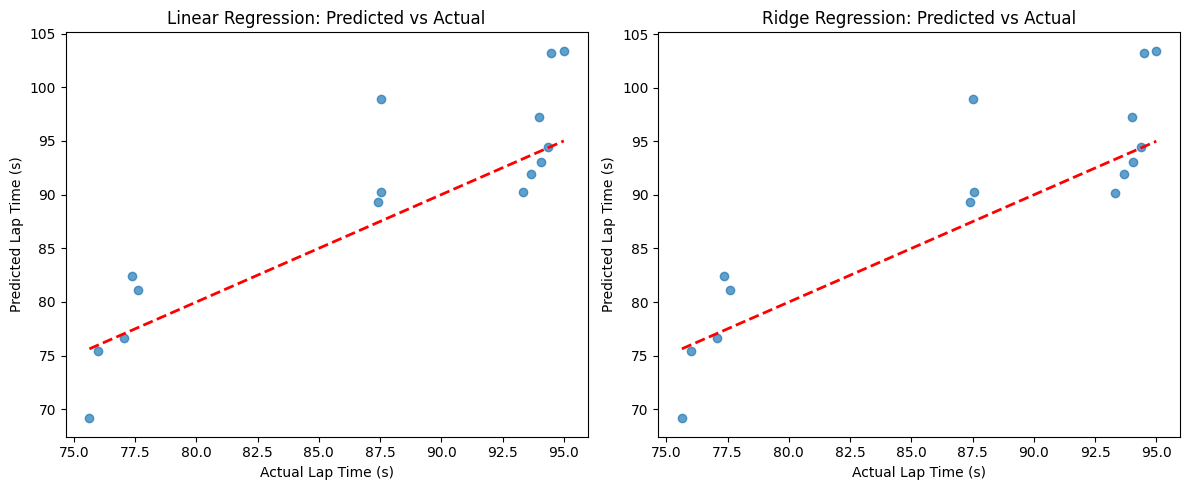


Overfitting Analysis:
Linear Regression gap: -4.749 seconds
Ridge Regression gap: -4.736 seconds


In [10]:
# TRAIN THE MODEL 
# I am using simpler regression models here because earlier tests with XGBoost and ANNs led to severe overfitting due to the lack of data (we only have 80 rows)
# Of course with time there is the option of...drumroll...getting MORE data. But due to time constraints this is what we have to work with.

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

drivers = train_df['Abbreviation'].copy()

# Encode categoricals
le_team = LabelEncoder()
le_race = LabelEncoder()

train_df['TeamId_encoded'] = le_team.fit_transform(train_df['TeamId'])
train_df['Race_encoded'] = le_race.fit_transform(train_df['Race'])

X = train_df.drop(columns=['Average Lap Time (s)', 'Abbreviation', 'TeamId', 'Race', 'WindSpeed'])
y = train_df['Average Lap Time (s)']

# Handle NaN values
X = X.fillna(0)

print(f"Dataset shape: {X.shape}")
print(f"Features: {list(X.columns)}")

X_train, X_test, y_train, y_test, drivers_train, drivers_test = train_test_split(
    X, y, drivers, test_size=0.25, random_state=42
)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

ridge_train_pred = ridge_model.predict(X_train)
ridge_test_pred = ridge_model.predict(X_test)

# Evaluate models
print("\n=== LINEAR REGRESSION ===")
print(f"Training MAE: {mean_absolute_error(y_train, lr_train_pred):.3f} seconds")
print(f"Test MAE: {mean_absolute_error(y_test, lr_test_pred):.3f} seconds")
print(f"Test R²: {r2_score(y_test, lr_test_pred):.3f}")

print("\n=== RIDGE REGRESSION ===")
print(f"Training MAE: {mean_absolute_error(y_train, ridge_train_pred):.3f} seconds")
print(f"Test MAE: {mean_absolute_error(y_test, ridge_test_pred):.3f} seconds")
print(f"Test R²: {r2_score(y_test, ridge_test_pred):.3f}")

# Feature importance 
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features (Linear Regression):")
print(feature_importance.head(10))

test_results = pd.DataFrame({
    'Driver': drivers_test,
    'Predicted_LapTime': lr_test_pred,
    'Actual_LapTime': y_test
}).sort_values('Predicted_LapTime')

print("\nPredicted Fastest 3 Drivers (Test Set):")
print(test_results.head(3))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, lr_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Lap Time (s)')
plt.ylabel('Predicted Lap Time (s)')
plt.title('Linear Regression: Predicted vs Actual')

plt.subplot(1, 2, 2)
plt.scatter(y_test, ridge_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Lap Time (s)')
plt.ylabel('Predicted Lap Time (s)')
plt.title('Ridge Regression: Predicted vs Actual')

plt.tight_layout()
plt.show()

# Check overfitting
overfitting_gap_lr = mean_absolute_error(y_test, lr_test_pred) - mean_absolute_error(y_train, lr_train_pred)
overfitting_gap_ridge = mean_absolute_error(y_test, ridge_test_pred) - mean_absolute_error(y_train, ridge_train_pred)

print(f"\nOverfitting Analysis:")
print(f"Linear Regression gap: {overfitting_gap_lr:.3f} seconds")
print(f"Ridge Regression gap: {overfitting_gap_ridge:.3f} seconds")

In [11]:
X

,GridPosition,Grid_Gap_to_Pole,Quali_vs_Teammate,Year,CleanAirPace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Pressure,Rain,Is_Zandvoort,TeamId_encoded,Race_encoded
0,1.0,0.0,-1.0,2024,70.961,0.259,3.0,19.005882,1019.981046,False,1,4,2
1,20.0,19.0,4.0,2024,71.430,0.728,-12.0,19.005882,1019.981046,False,1,3,2
2,11.0,10.0,-1.0,2024,71.374,0.672,-4.0,19.005882,1019.981046,False,1,6,2
3,18.0,17.0,-0.5,2024,71.818,1.116,-3.0,19.005882,1019.981046,False,1,9,2
4,14.0,13.0,5.0,2024,70.813,0.111,-11.0,19.005882,1019.981046,False,1,5,2
5,15.0,14.0,3.0,2024,72.061,1.359,2.0,19.005882,1019.981046,False,1,0,2
6,4.0,3.0,-5.0,2024,70.702,0.000,-3.0,19.005882,1019.981046,False,1,5,2
7,19.0,18.0,0.5,2024,71.550,0.848,-9.0,19.005882,1019.981046,False,1,9,2
8,5.0,4.0,1.5,2024,71.581,0.879,7.0,19.005882,1019.981046,False,1,7,2
9,17.0,16.0,0.5,2024,71.934,1.232,-1.0,19.005882,1019.981046,False,1,8,2


In [12]:
#----------------CREATE PREDICTION DATASET-----------------

predict_df=pd.DataFrame()
predict_df['Abbreviation']=['PIA','NOR','HAM','LEC','RUS','ANT','LAW','HAD','SAI','ALB','VER','TSU','ALO','STR','BEA','OCO','BOR','HUL','GAS','COL']

# Create driver to team mapping (2025 season)
driver_to_team = {
    'PIA': 'mclaren',
    'NOR': 'mclaren', 
    'HAM': 'ferrari',       
    'LEC': 'ferrari',
    'RUS': 'mercedes',
    'ANT': 'mercedes',      
    'LAW': 'rb',           
    'HAD': 'rb',
    'SAI': 'williams',       
    'ALB': 'williams',
    'VER': 'red_bull',
    'TSU': 'red_bull',           
    'ALO': 'aston_martin',
    'STR': 'aston_martin',
    'BEA': 'haas',          
    'OCO': 'haas',
    'BOR': 'sauber',       
    'HUL': 'sauber',
    'GAS': 'alpine',
    'COL': 'alpine'    
}

predict_df['TeamId'] = predict_df['Abbreviation'].map(driver_to_team)
predict_df['TeamId_encoded'] = le_team.transform(predict_df['TeamId'])

grid_positions = {
    'PIA': 1.0,
    'NOR': 2.0, 
    'HAM': 7.0,
    'LEC': 6.0,
    'RUS': 5.0,
    'ANT': 11.0,       
    'LAW': 8.0,          
    'HAD': 4.0,
    'SAI': 9.0,    
    'ALB': 15.0,
    'TSU': 12.0,            
    'ALO': 10.0,
    'STR': 20.0,
    'BEA': 19.0,          
    'OCO': 18.0,
    'BOR': 13.0,       
    'HUL': 17.0,
    'GAS': 14.0,
    'COL': 16.0  
}


predict_df['GridPosition'] = predict_df['Abbreviation'].map(grid_positions)
predict_df['Grid_Gap_to_Pole'] = predict_df['GridPosition'] - predict_df['GridPosition'].min()
predict_df['Quali_vs_Teammate'] = predict_df.groupby('TeamId')['GridPosition'].transform(lambda x: x - x.mean())

predict_df['Race'] = 'Zandvoort'
predict_df['Race_encoded'] = le_race.transform(predict_df['Race']) #2
predict_df['Year'] = 2025

predict_df['Is_Zandvoort']=1

clean_air_race_pace=get_clean_air_race_pace(2025,'Zandvoort')
clean_air_race_pace.drop(columns=['IsPersonalBest','Session'],inplace=True)
pace_mapping=clean_air_race_pace.set_index('Driver')['LapTime (s)']
predict_df['CleanAirPace_seconds'] = predict_df['Abbreviation'].map(pace_mapping)
        
predict_df['Practice_Gap_to_Fastest'] = predict_df['CleanAirPace_seconds'] - predict_df['CleanAirPace_seconds'].min()
predict_df['Practice_vs_Quali_Rank'] = predict_df['CleanAirPace_seconds'].rank() - predict_df['GridPosition']
predict_df['Quali_vs_Teammate'] = predict_df['Quali_vs_Teammate'].fillna(0)

        
#Predicted Air Temp: 21 Celsius, Pressure= 1008 mbar, windspeed 4 m/s and no Rainfall
predict_df['Rain']=False
predict_df['AirTemp'] = 21.000000
predict_df['Pressure']=1008.000000


predict_df.drop(columns=['TeamId'],inplace=True)
predict_df.drop(columns=['Race'],inplace=True)

predict_df

core           INFO 	Loading data for Dutch Grand Prix - Practice 1 [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '10', '12', '14', '16', '18', '22', '23', '27', '30', '31', '43', '44', '55', '63', '81', '87'

,Abbreviation,TeamId_encoded,GridPosition,Grid_Gap_to_Pole,Quali_vs_Teammate,Race_encoded,Year,Is_Zandvoort,CleanAirPace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,Rain,AirTemp,Pressure
0,PIA,4,1.0,0.0,-0.5,2,2025,1,69.214,0.242,1.0,False,21.0,1008.0
1,NOR,4,2.0,1.0,0.5,2,2025,1,68.972,0.000,-1.0,False,21.0,1008.0
2,HAM,2,7.0,6.0,0.5,2,2025,1,70.373,1.401,7.0,False,21.0,1008.0
3,LEC,2,6.0,5.0,-0.5,2,2025,1,69.938,0.966,0.0,False,21.0,1008.0
4,RUS,5,5.0,4.0,-3.0,2,2025,1,69.858,0.886,-2.0,False,21.0,1008.0
5,ANT,5,11.0,10.0,3.0,2,2025,1,70.697,1.725,6.0,False,21.0,1008.0
6,LAW,6,8.0,7.0,2.0,2,2025,1,70.300,1.328,3.0,False,21.0,1008.0
7,HAD,6,4.0,3.0,-2.0,2,2025,1,70.166,1.194,6.0,False,21.0,1008.0
8,SAI,9,9.0,8.0,-3.0,2,2025,1,69.913,0.941,-5.0,False,21.0,1008.0
9,ALB,9,15.0,14.0,3.0,2,2025,1,70.099,1.127,-7.0,False,21.0,1008.0


In [13]:
predict_df.columns

Index(['Abbreviation', 'TeamId_encoded', 'GridPosition', 'Grid_Gap_to_Pole',
       'Quali_vs_Teammate', 'Race_encoded', 'Year', 'Is_Zandvoort',
       'CleanAirPace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'Rain', 'AirTemp', 'Pressure'],
      dtype='object')

In [15]:
# Reorder prediction features to match training order
feature_order = ['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Year', 
                'CleanAirPace_seconds', 'Practice_Gap_to_Fastest', 'Practice_vs_Quali_Rank', 
                'AirTemp', 'Pressure', 'Rain', 'Is_Zandvoort', 'TeamId_encoded', 'Race_encoded']

X_predict = predict_df[feature_order]

# Handle missing values
X_predict = X_predict.fillna(0)

print("Feature alignment check:")
print("Training:", list(X.columns))
print("Prediction:", list(X_predict.columns))
print("Match:", list(X.columns) == list(X_predict.columns))

#Make Predictions
predicted_lap_times = lr_model.predict(X_predict)

results_df = pd.DataFrame({
    'Driver': predict_df['Abbreviation'],
    'Predicted_LapTime': predicted_lap_times
}).sort_values('Predicted_LapTime')

# Get top 3 fastest 
print("\nPREDICTED 2025 ZANDVOORT PODIUM")
print("===============================")
print(f"🥇 P1: {results_df.iloc[0]['Driver']} - {results_df.iloc[0]['Predicted_LapTime']:.3f}s")
print(f"🥈 P2: {results_df.iloc[1]['Driver']} - {results_df.iloc[1]['Predicted_LapTime']:.3f}s") 
print(f"🥉 P3: {results_df.iloc[2]['Driver']} - {results_df.iloc[2]['Predicted_LapTime']:.3f}s")

print("\nFull Results:")
print(results_df.head(10))

Feature alignment check:
Training: ['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Year', 'CleanAirPace_seconds', 'Practice_Gap_to_Fastest', 'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'Rain', 'Is_Zandvoort', 'TeamId_encoded', 'Race_encoded']
Prediction: ['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Year', 'CleanAirPace_seconds', 'Practice_Gap_to_Fastest', 'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'Rain', 'Is_Zandvoort', 'TeamId_encoded', 'Race_encoded']
Match: True

PREDICTED 2025 ZANDVOORT PODIUM
🥇 P1: PIA - 160153859764.430s
🥈 P2: NOR - 160153859764.852s
🥉 P3: HAD - 160153859766.680s

Full Results:
  Driver  Predicted_LapTime
0    PIA       1.601539e+11
1    NOR       1.601539e+11
7    HAD       1.601539e+11
6    LAW       1.601539e+11
4    RUS       1.601539e+11
8    SAI       1.601539e+11
3    LEC       1.601539e+11
2    HAM       1.601539e+11
5    ANT       1.601539e+11
9    ALB       1.601539e+11
